# Predicting PM2.5 concentrations via rolling forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from pm25_hyperparameters import *

data=pd.read_csv("BeijingPM_dataset.csv")
picker=data["date"]
picker_test=picker[(picker>="2015-09-01 00:00:00") & (picker<"2015-09-03 00:00:00")]
test_idx=list(picker_test.index)
data.drop("date",axis=1,inplace=True)
data.head()

,year,month,day,hour,season,PM,DEWP,HUMI,PRES,TEMP,...,precipitation_max,Iws_max,PM_max,TEMP_min,DEWP_min,HUMI_min,PRES_min,precipitation_min,Iws_min,PM_min
0,2010,1,3,0,4,63.0,-7.0,92.0,1027.0,-6.0,...,0.4,58.56,181.0,-14.0,-21.0,25.0,1014.0,0.0,0.89,63.0
1,2010,1,3,1,4,65.0,-8.0,85.0,1026.0,-6.0,...,0.5,61.69,181.0,-14.0,-21.0,25.0,1014.0,0.0,0.89,63.0
2,2010,1,3,2,4,55.0,-8.0,92.0,1026.0,-7.0,...,0.5,65.71,181.0,-14.0,-21.0,25.0,1014.0,0.0,0.89,55.0
3,2010,1,3,3,4,65.0,-8.0,92.0,1025.0,-7.0,...,0.7,68.84,181.0,-12.0,-20.0,25.0,1014.0,0.0,0.89,55.0
4,2010,1,3,4,4,83.0,-8.0,92.0,1024.0,-7.0,...,1.2,72.86,181.0,-10.0,-20.0,25.0,1014.0,0.0,0.89,55.0


## Parameters and functions used for model training and testing

In [2]:
x_met=["year","month","day","hour","season"]
y_met=list(set(prim_fea)-set(["PM"]))

datetime_cols=["is_holiday","is_special_event"]

x_pm=list(set(data.columns)-set(["PM"])-set(datetime_cols))

def fill_fea(df,pos,cols):
    df.loc[pos,]
    for col in cols:
        lagtmp=[]
        for t in range(1,lag_hours+1):
            if pos-t>=test_idx[0]:
                x=df.loc[pos-t,col]
            else:
                x=data.loc[pos-t,col]
            df.loc[pos,"%s_lag%d" % (col,t)]=x
            lagtmp.append(x)
        df.loc[pos,"%s_mean" % col]=np.mean(lagtmp)
        df.loc[pos,"%s_min" % col]=np.min(lagtmp)
        df.loc[pos,"%s_max" % col]=np.max(lagtmp)
        
lowbs=list(range(test_idx[0],test_idx[-1],24))

## Prepare the testing set for PM2.5 prediction

In [3]:
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor

pm_test_file="BeijingPM_test.csv"

met_fea={}
for col in y_met:
    met_fea[col]=[]
    for t in range(1,lag_hours+1):
        met_fea[col].append("%s_lag%d" % (col,t))
    for r in ["mean","max","min"]:
        met_fea[col].append("%s_%s" % (col,r))

if os.path.exists(pm_test_file):
    print("Reading the testing set from %s" % pm_test_file)
    pm_testset=pd.read_csv(pm_test_file)
else:
    pm_testset=data.loc[test_idx].copy()
    print("Creating testing set for [%d:%d]" % (test_idx[0],test_idx[-1]+1))
    pre={}
    for c in y_met:
        pre[c]=[]
    for i,lowb in enumerate(lowbs):
        met_train=data[:lowb]
        models={}
        for col in y_met:
            models[col]=LGBMRegressor()
            models[col].fit(met_train[x_met+met_fea[col]],met_train[col])
        for t in tqdm(range(lowb,lowb+24),desc="(%d/%d)" % (i+1,len(lowbs))):
            fill_fea(pm_testset,t,y_met)
            for col in y_met:
                pre[col].append(*models[col].predict(pm_testset.loc[[t],x_met+met_fea[col]]))
                pm_testset.loc[t,col]=pre[col][-1]
    pm_testset.to_csv(pm_test_file,index=False)

pm_testset.index=test_idx

Creating testing set for [49608:49656]


(2/2): 100%|██████████| 24/24 [00:02<00:00,  8.75it/s]


## Predict PM2.5

In [4]:
pm_predict_file="BeijingPM_prediction.csv"

pm_df_list=[]

# Parameters for PM2.5 prediction
pm_model_params={
    'objective': 'l2',
    'num_leaves': 64,
    'min_data_in_leaf': 20,
    'max_depth': 30,
    'learning_rate': 0.1,
    'feature_fraction': 1.0,
    'bagging_freq': 50,
    'bagging_fraction': 1.0,
    'verbose': -1
}


model_names=["LightGBM","LightGBM + holidays and special events"]

if os.path.exists(pm_predict_file):
    print("Reading existing PM2.5 prediction from %s" % pm_predict_file)
    pm_df=pd.read_csv(pm_predict_file)
else:
    print("Predicting PM2.5 for [%d:%d]" % (test_idx[0],test_idx[-1]))
    pm_test_control=pd.DataFrame(pm_testset,copy=True)
    pm_test_datetime=pd.DataFrame(pm_testset,copy=True)
    for i,lowb in enumerate(lowbs):
        pm_train=data[:lowb]
        pm_control=LGBMRegressor(random_state=101,**pm_model_params)
        pm_control.fit(pm_train[x_pm],pm_train["PM"])
        pm_datetime=LGBMRegressor(random_state=101,**pm_model_params)
        pm_datetime.fit(pm_train[x_pm+datetime_cols],pm_train["PM"])
        pm_predict_control=[]
        pm_predict_datetime=[]
        for k in tqdm(range(lowb,lowb+24),desc="[%d:%d] (%d/%d)" % (lowb,lowb+24,i+1,len(lowbs))):
            fill_fea(pm_test_control,k,["PM"])
            fill_fea(pm_test_datetime,k,["PM"])
            pm_predict_control.append(pm_control.predict(pm_test_control.loc[[k],x_pm])[0])
            pm_predict_datetime.append(pm_datetime.predict(pm_test_datetime.loc[[k],x_pm+datetime_cols])[0])
            pm_test_control.loc[k,"PM"]=pm_predict_control[-1]
            pm_test_datetime.loc[k,"PM"]=pm_predict_datetime[-1]

        pm_df_list.append(pd.DataFrame(
            {model_names[0]:pm_predict_control,model_names[1]:pm_predict_datetime}))
        pm_df=pd.concat(pm_df_list)
        pm_df.to_csv(pm_predict_file,index=False)

pm_df.index=test_idx

Predicting PM2.5 for [49608:49655]
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=50, subsample_freq=0 will be ignored. Current value: bagging_freq=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


[49608:49632] (1/2): 100%|██████████| 24/24 [00:01<00:00, 22.57it/s]


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=50, subsample_freq=0 will be ignored. Current value: bagging_freq=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


[49632:49656] (2/2): 100%|██████████| 24/24 [00:01<00:00, 21.01it/s]


## Model Evaluation

After predicting PM2.5 concentration, we now begin analyzing the performance. In our study, we use three evaluation metrics to rank our model (let $y_i$ be the true value and $p_i$ be the predicted values).

$$MAE=\frac1N\sum_{i=1}^N|y_i-p_i|\quad RMSE=\sqrt{\frac1N\sum_{i=1}^N(y_i-p_i)^2}\quad SMAPE=\frac1N\sum_{i=1}^N\frac{|y_i-p_i|}{(|y_i|+|p_i|)/2}$$

In [5]:
# Combine true values and predicted values for comparison
pm_comp=pd.concat([data.loc[pm_df.index,"PM"],pm_df],axis=1)
pm_comp.index=picker[test_idx]

def get_mae(y,p):
    return abs(y-p).mean()

def get_rmse(y,p):
    return np.sqrt(np.square(y-p).mean())

def get_smape(y,p):
    return 1/len(y)*np.sum(2*abs(y-p)/(abs(y)+abs(p)+1e-7))

eval_metrics={"MAE":get_mae,"RMSE":get_rmse,"SMAPE":get_smape}

def pm_metrics(col,m):
    return eval_metrics[m](pm_comp["PM"],pm_comp[col])

pm_metrics={}

for m in eval_metrics.keys():
    pm_metrics[m]=[]

for col in ["LightGBM","LightGBM + holidays and special events"]:
    for m in pm_metrics.keys():
        pm_metrics[m].append(eval_metrics[m](pm_comp["PM"],pm_comp[col]))

edf=pd.DataFrame(pm_metrics,index=["LightGBM","LightGBM + holidays and special events"])
edf.to_csv("model_scores.csv")
edf

,MAE,RMSE,SMAPE
LightGBM,5.319195,7.671777,0.444225
LightGBM + holidays and special events,4.783741,6.535935,0.427308


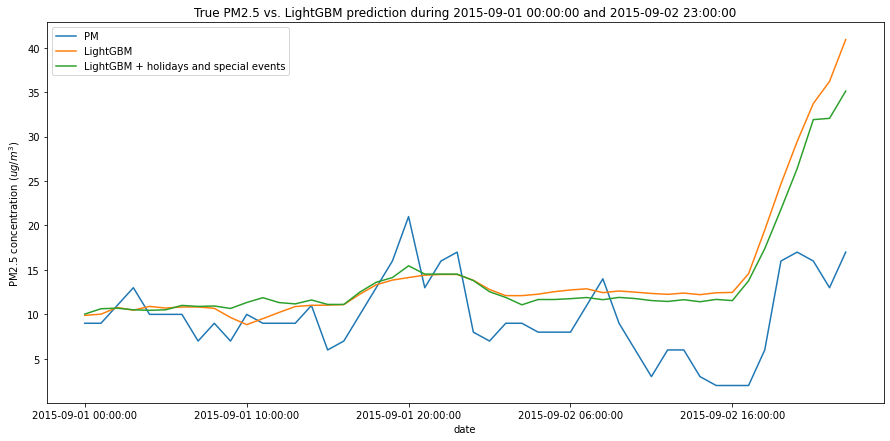

In [6]:
plt.figure(figsize=(15,7))
ax=plt.gca()
ax.set_title("True PM2.5 vs. LightGBM prediction during %s and %s" % (pm_comp.index[0],pm_comp.index[-1]))
ax.set_ylabel("PM2.5 concentration ($ug/m^3$)")
pm_comp[["PM",*model_names[:2]]].plot(ax=ax)

plt.savefig("graphs/lgbm_prediction.png")